In [250]:
import yfinance as yf

In [251]:
ticker = '^GSPC'

sp500 = yf.Ticker(ticker)

In [252]:
sp500 = sp500.history(period='20y')

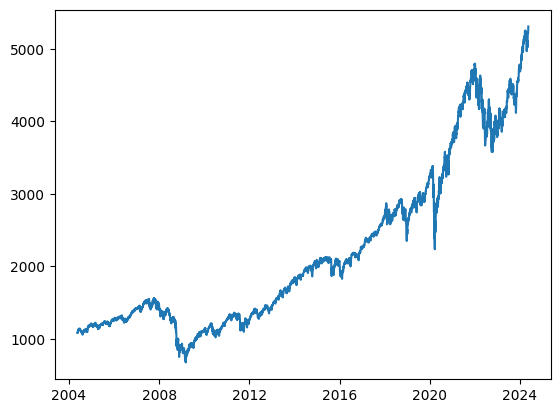

In [253]:
import matplotlib.pyplot as plt

plt.plot(sp500['Close'])

In [254]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500['Target'] = sp500['Tomorrow'] > sp500['Close']

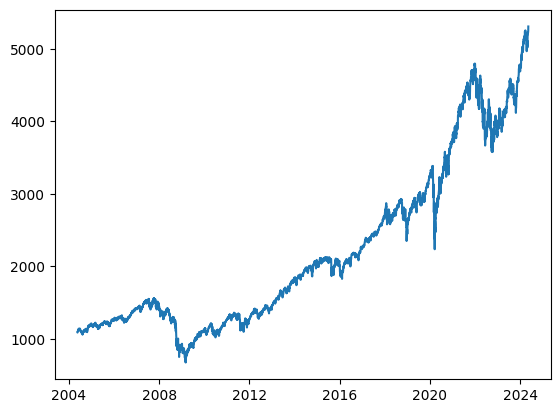

In [255]:
plt.clf()

plt.plot(sp500['Tomorrow'])

In [256]:
sp500 = sp500.dropna()

del sp500['Volume']

In [257]:
timesteps = 10

features = sp500.shape[1] - 1

y = sp500.drop(columns="Target").values

num_samples = y.shape[0] // timesteps

y = y[:num_samples*timesteps]

y = y.reshape((num_samples, timesteps, features))

In [258]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

seq = Sequential()

seq.add(Input(shape=(timesteps, features)))
seq.add(LSTM(50, return_sequences=True))
seq.add(LSTM(50, return_sequences=True))
seq.add(LSTM(50))
seq.add(Dense(1, activation='sigmoid'))

seq.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [259]:
seq.fit(y, sp500['Target'].values[:num_samples*timesteps].reshape((num_samples, timesteps, 1)), epochs=100, batch_size=128, validation_split=0.05)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4932 - loss: 0.2493 - val_accuracy: 0.5500 - val_loss: 0.2477
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5504 - loss: 0.2475 - val_accuracy: 0.5500 - val_loss: 0.2475
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5470 - loss: 0.2478 - val_accuracy: 0.5500 - val_loss: 0.2478
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5459 - loss: 0.2480 - val_accuracy: 0.5500 - val_loss: 0.2473
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5413 - loss: 0.2483 - val_accuracy: 0.5500 - val_loss: 0.2475
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5412 - loss: 0.2484 - val_accuracy: 0.5500 - val_loss: 0.2477
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5404 - loss: 0.2482 - val_accuracy: 0.5500 - val_loss: 0.2475
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5469 - loss: 0.2477 - val_accuracy: 0.5500 - val_loss:

KeyboardInterrupt: 

In [ ]:
import yfinance as yf
ticker = '^GSPC'
sp500 = yf.Ticker(ticker)
sp500 = sp500.history(period='20y')


In [ ]:
sp500 = sp500.reset_index()['Close']

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sp500)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

sp500 = scaler.fit_transform(np.array(sp500).reshape(-1, 1))

In [ ]:
sp500.shape

In [ ]:
train_size = int(len(sp500) * 0.8)
test_size = len(sp500) - train_size

train, test = sp500[0:train_size,:], sp500[train_size:len(sp500),:]

In [ ]:
plt.clf()
plt.plot(train)

In [ ]:
import numpy as np

In [ ]:
def createDataSet(dataset, timesteps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-timesteps-1):
        a = dataset[i:(i+timesteps), 0]
        dataX.append(a)
        dataY.append(dataset[i + timesteps, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step=100
trainX, trainY = createDataSet(train, time_step)
testX, testY = createDataSet(test, time_step)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

seq = Sequential()
seq.add(LSTM(50, recurrent_dropout=0.05, input_shape=(trainX.shape[1],1), return_sequences=True))
seq.add(LSTM(50, return_sequences=True))
seq.add(LSTM(50))
seq.add(Dense(1))


seq.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
seq.summary()

In [ ]:
seq.fit(trainX, trainY, epochs=120, batch_size=64, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=5)])

In [ ]:

testX.shape

In [ ]:
trainPredict = seq.predict(trainX)
testPredict = seq.predict(testX)


In [ ]:
from sklearn.metrics import mean_squared_error
import math

In [ ]:
trainPredict.shape

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)

In [ ]:
testPredict = scaler.inverse_transform(testPredict)

In [ ]:
print(math.sqrt(mean_squared_error(trainY, trainPredict[:,0])))
print(math.sqrt(mean_squared_error(testY, testPredict[:,0])))

In [ ]:
look = 100

trainPredictPlot = np.empty_like(sp500)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look:len(trainPredict)+look, :] = trainPredict

testPredictPlot = np.empty_like(sp500)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look*2)+1:len(sp500)-1, :] = testPredict


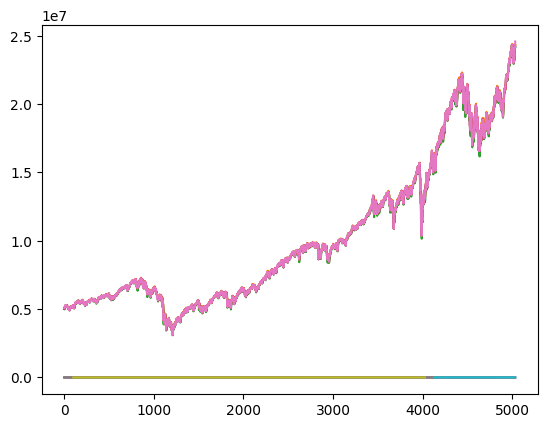

In [266]:
plt.plot(scaler.inverse_transform(sp500))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [260]:
import pickle as p

p.dump(seq, open('stockLSTM.pkl', 'wb'))

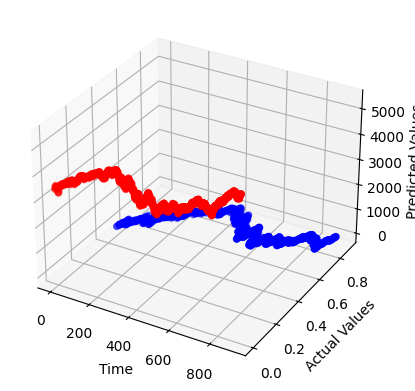

In [270]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a time array
time = np.arange(testX.shape[0])

# Plot the actual values
ax.scatter(time, testX[:,0], np.zeros_like(testX[:,0]), color='b')

# Plot the predicted values
ax.scatter(time, np.zeros_like(testPredict[:,0]), testPredict[:,0], color='r')

ax.set_xlabel('Time')
ax.set_ylabel('Actual Values')
ax.set_zlabel('Predicted Values')

plt.show()

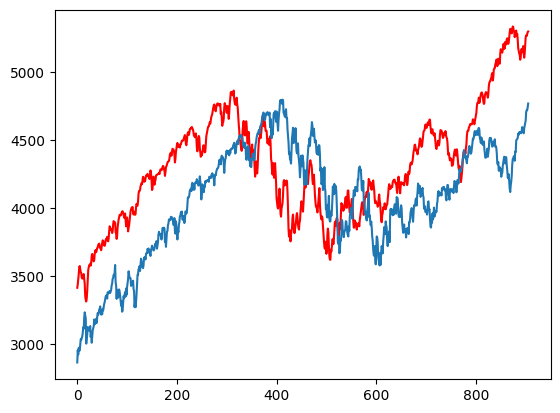

In [279]:
plt.clf()
plt.plot(testPredict, c='r')
plt.plot(scaler.inverse_transform(testX[:,0].reshape(-1, 1)))

In [280]:
p.dump(scaler, open('vectorizers/scaler.pkl', 'wb'))